## Pipeline with breast cancer data of cBioPortal to check link between high proliferation/ Invasion and low Apoptosis with worse survival outcome

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import maboss
import gseapy as gp
from scipy.stats import spearmanr
import pandas as pd
import os
from pathlib import Path

from functions.validation_utils.validation_Breast import (
    process_montagud_nodes,process_montagud_nodes_synonyms, process_genes, pre_process_mutations, preprocess_cnv,create_generic_patients_cfgs_bnds, personalized_patients_genes_cfgs, generic_models_update_phenotypes, tailor_bnd_cnv_cm, correlate_boolean_predictions_with_gene_signatures, compute_phenotype_table, combine_patient_results, survival_analysis_comparison
)


from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import collect_group_data

In [6]:
import logging

logger = logging.getLogger(__name__)

### Loading the dataset

In [ ]:
#  somatic mutations, copy number alterations, and gene expression
# 2509 models


# genes_data = pd.read_csv('data/cBioPortal/data_mrna_illumina_microarray_zscores_ref_diploid_samples.txt', sep='\t')


import pandas as pd
import os
# try with raw data
rna_seq_breast = pd.read_csv('data/cBioPortal/data_mrna_illumina_microarray.txt',sep='\t')

mutations_data = pd.read_csv('data/cBioPortal/data_mutations.txt', sep='\t', skiprows=1)
cnv_data = pd.read_csv('data/cBioPortal/data_cna.txt', sep='\t')
clinical_patients_data = pd.read_csv('data/cBioPortal/data_clinical_patient.txt', sep='\t',skiprows=4)
clinical_samples = pd.read_csv('data/cBioPortal/data_clinical_sample.txt',sep='\t',skiprows=4)
nodes_montagud_synonyms = pd.read_csv('data/fumia_models/nodes_processed.txt',sep='\t')


montagud_original_data_df = (
    pd.read_csv('data/montagud_models/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])




onco_tsg_data = pd.read_csv('data/oncogenes_tsg.tsv',sep='\t')

from functions.validation_utils.validation_Breast import process_montagud_nodes_synonyms, process_montagud_nodes, process_genes, preprocess_cnv, pre_process_mutations, create_generic_patients_cfgs_bnds, generic_models_update_phenotypes, tailor_bnd_cnv_cm, personalized_patients_genes_cfgs, compute_phenotype_table, survival_analysis_comparison, combine_patient_results, correlate_boolean_predictions_with_gene_signatures

In [ ]:
def main_validation(normalization_method, nb_patient, rna_seq_breast, discrete_variable, continuous_variable, phenotypes_interest, inputs_list):
    folder_generic_models = 'data/fumia_models'
    folder_models = f'analysis/validation_Breast/{discrete_variable}_{continuous_variable}/{normalization_method}/models'
    results_folder = f'analysis/validation_Breast/{discrete_variable}_{continuous_variable}/{normalization_method}/results'


    os.makedirs(folder_models, exist_ok=True)
    type_personalization = discrete_variable

    clinical_patients_data_test = clinical_patients_data[clinical_patients_data['NPI'].notna()]
    clinical_patients_data_test = clinical_patients_data_test[['PATIENT_ID', 'NPI', 'OS_MONTHS', 'OS_STATUS']]
    clinical_patients_data_test = clinical_patients_data_test[clinical_patients_data_test['OS_MONTHS'].notna() & clinical_patients_data_test['OS_STATUS'].notna()]

    # Sort by NPI
    clinical_sorted = clinical_patients_data_test.sort_values('NPI')

    # Select lowest NPI (best prognosis)
    nb_patient_group = nb_patient// 2
    low_npi_patients = clinical_sorted.head(nb_patient_group)['PATIENT_ID'].tolist()

    # Select highest NPI (worst prognosis)  
    high_npi_patients = clinical_sorted.tail(nb_patient_group)['PATIENT_ID'].tolist()
    patients_ids = low_npi_patients + high_npi_patients


    # Keep Hugo_Symbol, Entrez_Gene_Id, and patient columns
    rna_seq_breast_filtered = rna_seq_breast[['Hugo_Symbol', 'Entrez_Gene_Id'] + 
                                [col for col in rna_seq_breast.columns if col in patients_ids]]


    cnv_data_filtered = cnv_data[['Hugo_Symbol', 'Entrez_Gene_Id'] + 
                                [col for col in cnv_data.columns if col in patients_ids]]


    mutations_data_filtered = mutations_data[mutations_data['Tumor_Sample_Barcode'].isin(patients_ids)]

    clinical_patients_data_filtered = clinical_patients_data[clinical_patients_data['PATIENT_ID'].isin(patients_ids)]


    montagud_node_synonyms, synonyms_to_nodes_dict = process_montagud_nodes_synonyms(nodes_montagud_synonyms)
    montagud_node_model, all_montagud_nodes = process_montagud_nodes(
        montagud_original_data_df, montagud_node_synonyms)
    
    
    rna_seq_data_final = process_genes(patients_ids, rna_seq_breast_filtered, all_montagud_nodes, synonyms_to_nodes_dict)
    cnv_data_filt = preprocess_cnv(patients_ids, cnv_data_filtered, all_montagud_nodes, synonyms_to_nodes_dict)
    mutations_data_filtered =  pre_process_mutations(patients_ids, mutations_data_filtered, onco_tsg_data, all_montagud_nodes, synonyms_to_nodes_dict)


    create_generic_patients_cfgs_bnds(
    folder_generic_models,
    folder_models,
    patients_ids,
)
    
    generic_models_update_phenotypes(phenotypes_interest, folder_models)

    if discrete_variable == 'mutations':
        tailor_bnd_cnv_cm(mutations_data_filtered, folder_models)
        logger.debug('mutations selected')

    elif discrete_variable == 'cnv':
        tailor_bnd_cnv_cm(cnv_data_filt, folder_models)
        logger.debug('cnv selected')
    elif discrete_variable == 'cnv_mutations':
        tailor_bnd_cnv_cm(cnv_data_filt, folder_models)
        tailor_bnd_cnv_cm(mutations_data_filtered, folder_models)
        logger.debug('mutations and cnv selected')

    else:
        logger.debug('select between mutations or cnv or cnv_mutations')

    personalized_patients_genes_cfgs(
    rna_seq_data_final,
    all_montagud_nodes,
    folder_models,
    amplif_factor = 100,
    normalization_method = normalization_method
)
    
    for patient in patients_ids:
        results_maboss = compute_phenotype_table(
            results_folder,
            folder_models,
            patient,
            inputs_list,
            phenotypes_interest,
        )
    combined_results = combine_patient_results(results_folder)
    # combined_results = pd.read_csv('analysis/validation_Breast/mutations_genes/sigmoid/results/combined_patients_ids.csv')

        # Create groups based on proliferation level and then apoptosis level
    combined_results_survival = combined_results.copy()
    combined_results_survival['Group_Proliferation'] = np.where(
        combined_results_survival['Proliferation'] < combined_results['Proliferation'].mean(), 
        'low', 
        'high'
    )

    # You can also create groups for Apoptosis
    combined_results_survival['Group_Apoptosis'] = np.where(
        combined_results_survival['Apoptosis'] < combined_results['Apoptosis'].mean(), 
        'low', 
        'high'
    )

    # Processing survival data

    survival_columns = [
        'PATIENT_ID',           # Patient identifier
        'OS_MONTHS',            # Overall survival time (months)
        'OS_STATUS',            # Overall survival status (0=alive, 1=dead)
    ]

    clinical_patients_data_filtered = clinical_patients_data_filtered[survival_columns]
    clinical_patients_ids = list(set(clinical_patients_data_filtered['PATIENT_ID']))


    # merge the two 
    # Same as above but using the dataframe method
    survival_analysis_data = clinical_patients_data_filtered.merge(
        combined_results, 
        left_on='PATIENT_ID', 
        right_on='patient_id', 
        how='inner'
    )


    survival_analysis_data['OS_STATUS'] = survival_analysis_data['OS_STATUS'].map({
            '0:LIVING': 0,
            '1:DECEASED': 1,
            'LIVING': 0,
            'DECEASED': 1,
            0: 0,
            1: 1
        })


    survival_analysis_data['Group_Proliferation'] = np.where(
        survival_analysis_data['Proliferation'] < survival_analysis_data['Proliferation'].median(), 
        'low', 
        'high'
    )

    # You can also create groups for Apoptosis using median
    survival_analysis_data['Group_Apoptosis'] = np.where(
        survival_analysis_data['Apoptosis'] < survival_analysis_data['Apoptosis'].median(), 
        'low', 
        'high'
    )

    # Use the updated function
    survival_analysis_comparison(
        normalization_method,
        discrete_variable,
        continuous_variable,
        survival_analysis_data, 
        'Group_Proliferation', 
        save_plots=True
    )

    survival_analysis_comparison(
        normalization_method,
        discrete_variable,
        continuous_variable,
        survival_analysis_data, 
        'Group_Apoptosis',
        save_plots=True
    )




    rna_seq_breast_filtered['Hugo_Symbol'] = rna_seq_breast_filtered['Hugo_Symbol'].str.strip()

        # Transform from wide to long format
    rna_seq_data_long = rna_seq_breast_filtered.melt(
        id_vars=['Hugo_Symbol', 'Entrez_Gene_Id'],  # Keep these columns as identifiers
        value_vars=rna_seq_breast_filtered.columns[2:],  # Patient columns to melt
        var_name='patient_id',  # Name for the new column containing patient IDs
        value_name='expression_value'  # Name for the new column containing expression values
    )

    rna_seq_data_final = rna_seq_data_long[['patient_id', 'Hugo_Symbol', 'expression_value']]
    rna_seq_data_final = rna_seq_data_final.rename(columns={'Hugo_Symbol': 'gene_symbol', 'patient_id':'model_id', 'expression_value':'rsem_tpm'})
    
     # Strip whitespace from gene_symbol column
    rna_seq_data_final['gene_symbol'] = rna_seq_data_final['gene_symbol'].str.strip()


    results_corr_apoptosis_df, correlation_data = correlate_boolean_predictions_with_gene_signatures(True, combined_results, 'Apoptosis', 'Apoptosis', rna_seq_breast, patients_ids)
    results_corr_prolife_df, correlation_data = correlate_boolean_predictions_with_gene_signatures(True, combined_results, 'G2-M Checkpoint', 'Proliferation', rna_seq_breast, patients_ids)
    results_corr_apoptosis_df.to_csv(f'{results_folder}/outputs/results_corr_apoptosis_df')
    results_corr_prolife_df.to_csv(f'{results_folder}/outputs/results_corr_prolife_df')



    # correlation to NIP 
    clinical_patients_data_NPI = clinical_patients_data[clinical_patients_data['PATIENT_ID'].isin(patients_ids)]
    clinical_patients_data_NPI = clinical_patients_data_NPI[['PATIENT_ID', 'NPI']]

    clinical_patients_data_NPI = clinical_patients_data_NPI.merge(
        combined_results, 
        left_on='PATIENT_ID', 
        right_on='patient_id'
    )

    phenotypes_list = ['Proliferation', 'Apoptosis']
    corr_NPI_results_df = pd.DataFrame(index=phenotypes_list, columns = ['Correlation', 'P-value'])

    for phenotype in phenotypes_list:
        corr, pval = spearmanr(list(clinical_patients_data_NPI['NPI']), list(clinical_patients_data_NPI[phenotype]))
        corr_NPI_results_df.loc[phenotype, 'Correlation'] = corr
        corr_NPI_results_df.loc[phenotype, 'P-value'] = pval
    results_folder_output = f'{results_folder}/outputs/NPI_correlation.csv'
    corr_NPI_results_df.to_csv(results_folder_output)





/Users/romane/repos/icr/Attractor-Resistance/functions/validation_utils/validation_Breast.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_seq_data_filtered['Hugo_Symbol'] = rna_seq_data_filtered['Hugo_Symbol'].str.strip()


 Duplicated MTOR: mTORC1 (1 rows) + mTORC2 (1 rows)
 Duplicated MYC: MYC (1 rows) + MYC_MAX (1 rows)
 Duplicated PIK3CA: PI3K (1 rows) + PIP3 (1 rows)
 Duplicated LDHA: LDHA (1 rows) + Lactic_acid (1 rows)
 Duplicated ERG: AR_ERG (1 rows) + ERG (1 rows)
Created files for patient MB-0281
Created files for patient MB-0284
Created files for patient MB-0351
Created files for patient MB-0333
Created files for patient MB-0876
Created files for patient MB-5186
Created files for patient MB-7217
Created files for patient MB-0472
Created files for patient MB-4839
Created files for patient MB-0260
Created files for patient MB-0245
Created files for patient MB-5174
Created files for patient MB-2821
Created files for patient MB-4681
Created files for patient MB-0318
Created files for patient MB-4145
Created files for patient MB-5278
Created files for patient MB-0539
Created files for patient MB-7249
Created files for patient MB-0160
Created files for patient MB-3797
Created files for patient MB-543

/Users/romane/repos/icr/Attractor-Resistance/functions/generate_utils/pre_process_data/pre_process_genes.py:189: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_zero_inflation[results_zero_inflation['is_zero_inflated'].fillna(False) == True].index


no genes with zero distribution
no genes with zero distribution
==== Processing all genes per patient ===

Processing file: MB-5186.cfg
  No data for HIF1A
  No data for CDKN2B
  No data for RPS6KA1
  No data for ANAPC1
  No data for E2F6
  No data for CCNB3
  No data for NFKB1
  No data for MAPK8
  No data for NTRK1
  No data for CCNE2
  No data for SMAD2
  No data for E2F3
  No data for ADCY1
  No data for SMAD4
  No data for VEGFB
  No data for TSC2
  No data for FLT3
  No data for GLI2
  No data for CDC20
  No data for E2F7
  No data for ARAF
  No data for RAG1
  No data for CCND2
  No data for NOX1
  No data for FLT4
  No data for NRAS
  No data for CTNNB1
  No data for BAK1
  No data for MDM2
  No data for CCNB2
  No data for AKT1
  No data for CASP9
  No data for CFLAR
  No data for CDH1
  No data for CDKN1A
  No data for GSS
  No data for nan
  No data for CCND3
  No data for PRKCA
  No data for KRAS
  No data for VEGFA
  No data for GLI1
  No data for GSK3A
  No data for NTRK2

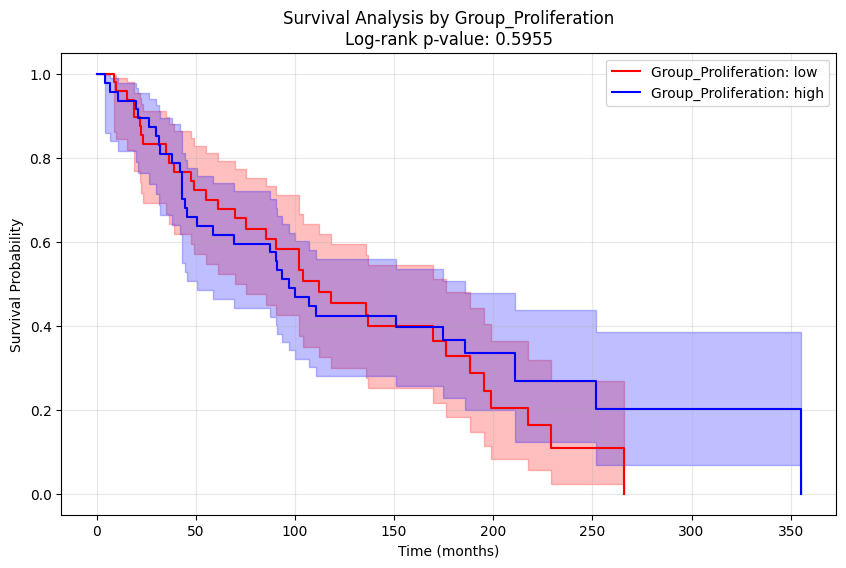

Group 'high': 50 patients
Group 'low': 50 patients

Log-rank test:
Test statistic: 0.1926
p-value: 0.6607
Significant difference (α=0.05): False

Plot saved to: analysis/validation_Breast/mutations_genes/distribution_normalization/results/outputs/survival_analysis_group-apoptosis.png


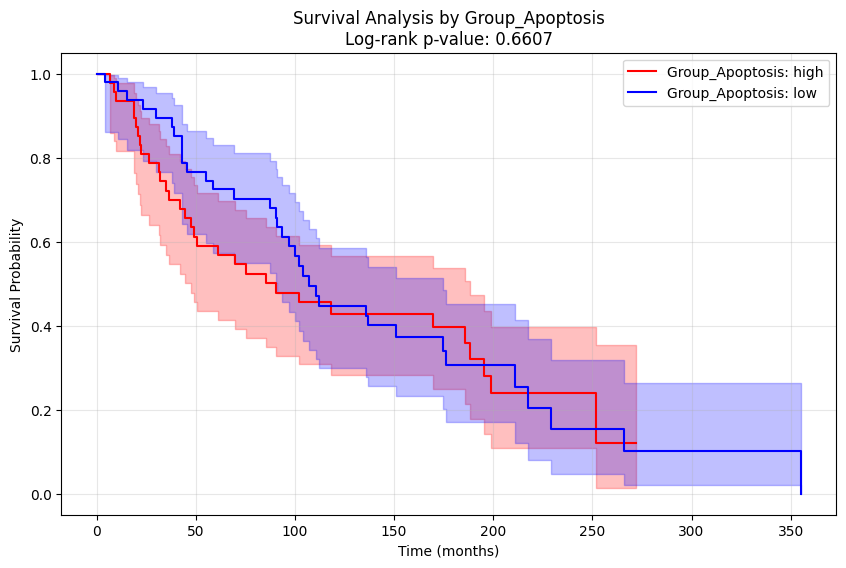

/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_73695/4006701043.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_seq_breast_filtered['Hugo_Symbol'] = rna_seq_breast_filtered['Hugo_Symbol'].str.strip()
/Users/romane/repos/icr/Attractor-Resistance/functions/validation_utils/validation_Breast.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_seq_data_filtered['Hugo_Symbol'] = rna_seq_data_filtered['Hugo_Symbol'].str.strip()


 Duplicated MTOR: mTORC1 (1 rows) + mTORC2 (1 rows)
 Duplicated MYC: MYC (1 rows) + MYC_MAX (1 rows)
 Duplicated PIK3CA: PI3K (1 rows) + PIP3 (1 rows)
 Duplicated LDHA: LDHA (1 rows) + Lactic_acid (1 rows)
 Duplicated ERG: AR_ERG (1 rows) + ERG (1 rows)
Created files for patient MB-0281
Created files for patient MB-0284
Created files for patient MB-0351
Created files for patient MB-0333
Created files for patient MB-0876
Created files for patient MB-5186
Created files for patient MB-7217
Created files for patient MB-0472
Created files for patient MB-4839
Created files for patient MB-0260
Created files for patient MB-0245
Created files for patient MB-5174
Created files for patient MB-2821
Created files for patient MB-4681
Created files for patient MB-0318
Created files for patient MB-4145
Created files for patient MB-5278
Created files for patient MB-0539
Created files for patient MB-7249
Created files for patient MB-0160
Created files for patient MB-3797
Created files for patient MB-543

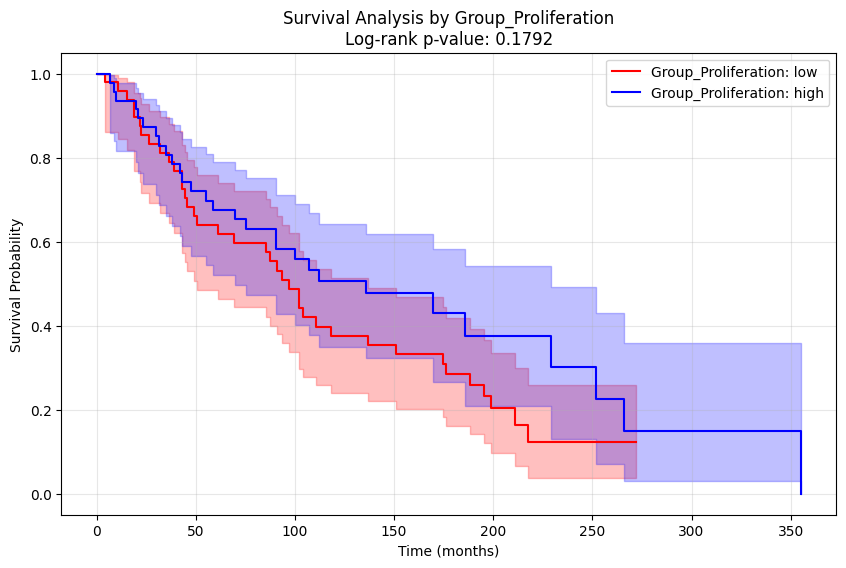

Group 'high': 50 patients
Group 'low': 50 patients

Log-rank test:
Test statistic: 1.3812
p-value: 0.2399
Significant difference (α=0.05): False

Plot saved to: analysis/validation_Breast/mutations_genes/global_log/results/outputs/survival_analysis_group-apoptosis.png


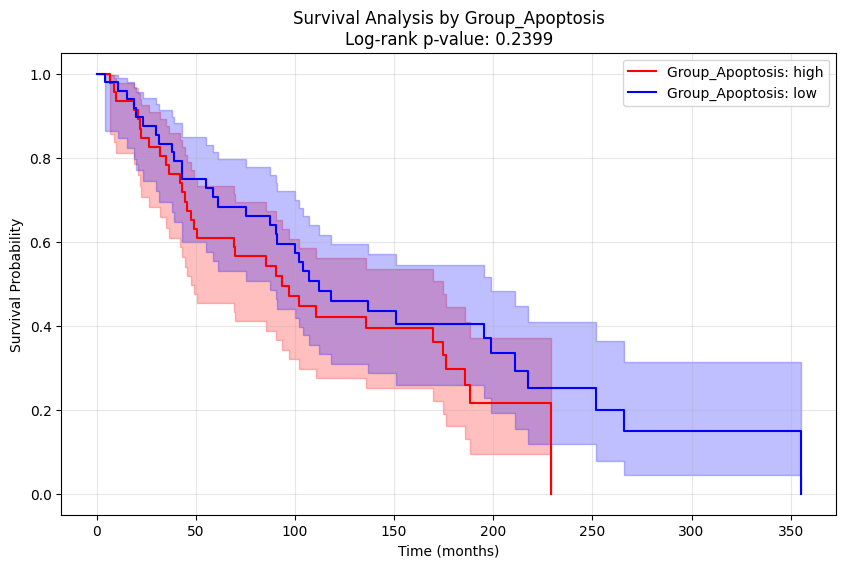

/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_73695/4006701043.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_seq_breast_filtered['Hugo_Symbol'] = rna_seq_breast_filtered['Hugo_Symbol'].str.strip()


In [5]:
import os
import numpy as np

nb_patient = 100
discrete_variable = 'mutations'
continuous_variable = 'genes'

phenotypes_interest = ["Proliferation","Apoptosis"]
inputs_list = ['GLI', 'MAX', 'PTEN', 'Acidosis', 'p14ARF', 'ROS', 'Hypoxia', 'Nutrients', 'Carcinogen', 'GFs', 'TNFalpha']

normalization_techniques = ['distribution_normalization','global_log']
# normalization_techniques = ['sigmoid', 'min-max','log_transf','global_minmax', 'global_log']

for normalization_method in normalization_techniques:
    main_validation(normalization_method, nb_patient, rna_seq_breast, discrete_variable, continuous_variable, phenotypes_interest, inputs_list)



## Correlation to the NPI values

In [ ]:
import pandas as pd
combined_results = pd.read_csv('analysis/validation_Breast/mutations_genes/global_minmax/results/combined_patients_ids.csv')
combined_results

,patient_id,Proliferation,Apoptosis
0,MB-4697,0.040049,0.093403
1,MB-4126,0.172264,0.095097
2,MB-7188,0.112131,0.086393
3,MB-4324,0.105188,0.054977
4,MB-0156,0.250587,0.092918
...,...,...,...
95,MB-7231,0.066438,0.088290
96,MB-4711,0.168231,0.048264
97,MB-0173,0.099520,0.093991
98,MB-2758,0.143661,0.090987


In [ ]:
clinical_patients_data

,PATIENT_ID,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,COHORT,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,SEX,INTCLUST,AGE_AT_DIAGNOSIS,OS_MONTHS,OS_STATUS,CLAUDIN_SUBTYPE,THREEGENE,VITAL_STATUS,LATERALITY,RADIO_THERAPY,HISTOLOGICAL_SUBTYPE,BREAST_SURGERY,RFS_MONTHS,RFS_STATUS
0,MB-0000,10.0,6.044,NaN,NO,1.0,Positve,NEUTRAL,YES,Post,Female,4ER+,75.65,140.500000,0:LIVING,claudin-low,ER-/HER2-,Living,Right,YES,Ductal/NST,MASTECTOMY,140.500000,0:Not Recurred
1,MB-0002,0.0,4.020,High,NO,1.0,Positve,NEUTRAL,YES,Pre,Female,4ER+,43.19,84.633333,0:LIVING,LumA,ER+/HER2- High Prolif,Living,Right,YES,Ductal/NST,BREAST CONSERVING,84.633333,0:Not Recurred
2,MB-0005,1.0,4.030,High,YES,1.0,Positve,NEUTRAL,YES,Pre,Female,3,48.87,163.700000,1:DECEASED,LumB,NaN,Died of Disease,Right,NO,Ductal/NST,MASTECTOMY,153.300000,1:Recurred
3,MB-0006,3.0,4.050,Moderate,YES,1.0,Positve,NEUTRAL,YES,Pre,Female,9,47.68,164.933333,0:LIVING,LumB,NaN,Living,Right,YES,Mixed,MASTECTOMY,164.933333,0:Not Recurred
4,MB-0008,8.0,6.080,High,YES,1.0,Positve,NEUTRAL,YES,Post,Female,9,76.97,41.366667,1:DECEASED,LumB,ER+/HER2- High Prolif,Died of Disease,Right,YES,Mixed,MASTECTOMY,18.800000,1:Recurred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2504,MTS-T2428,0.0,2.540,NaN,NaN,1.0,Positve,NaN,NaN,NaN,Female,NaN,70.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,1:Recurred
2505,MTS-T2429,0.0,4.560,NaN,NaN,1.0,Positve,NaN,NaN,NaN,Female,NaN,63.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.400000,1:Recurred
2506,MTS-T2430,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2507,MTS-T2431,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
patients_ids = ['MB-4697', 'MB-0173', 'MB-0403']

clinical_patients_data_NPI = clinical_patients_data[clinical_patients_data['PATIENT_ID'].isin(patients_ids)]
clinical_patients_data_NPI = clinical_patients_data_NPI[['PATIENT_ID', 'NPI']]

clinical_patients_data_NPI = clinical_patients_data_NPI.merge(
    combined_results, 
    left_on='PATIENT_ID', 
    right_on='patient_id'
)

phenotypes_list = ['Proliferation', 'Apoptosis']
corr_NPI_results_df = pd.DataFrame(index=phenotypes_list, columns = ['Correlation', 'P-value'])

for phenotype in phenotypes_list:
    corr, pval = spearmanr(list(clinical_patients_data_NPI['NPI']), list(clinical_patients_data_NPI[phenotype]))
    corr_NPI_results_df.loc[phenotype, 'Correlation'] = corr
    corr_NPI_results_df.loc[phenotype, 'P-value'] = pval


results_folder = 'analysis/validation_Breast/mutations_genes/global_minmax/results'
results_folder_output = f'{results_folder}/outputs/NPI_correlation.csv'
corr_NPI_results_df.to_csv(results_folder_output)


In [ ]:
# compute correlation between NPI and probability 


# inactivating mutations (nonsense, frame-shift insertions or deletions and mutation in splice or translation start sites)



# === Assumption ===
# mutations targeting oncogenes -> gain of function
# mutations targeting Tumor suppressor genes -> loss of function


# SIFT and  PolyPhen scores

